
# Classificador de Risco de Sintomas (Triagem Clínica)
Este notebook constrói um **classificador binário** que analisa frases com sintomas e classifica o nível de risco como **“baixo risco”**, **"médio risco”** ou **“alto risco”**.

**Pipeline em alto nível:**
1. Carrega o dataset CSV de frases rotuladas.
2. Pré-processa e filtra as classes de interesse.
3. Transforma texto em vetores com **TF‑IDF**.
4. Treina um modelo de **Regressão Logística**.
5. Avalia o desempenho (acurácia, relatório de classificação, matriz de confusão).
6. Testa frases novas e inspeciona erros para observar padrões/distorções.



## 1) (Opcional) Instalação de dependências
> Execute **apenas se necessário** no seu ambiente local (ex.: Google Colab).  
Se as bibliotecas já estiverem disponíveis, você pode **pular** esta etapa.


In [ ]:

# Descomente se precisar instalar
%pip install -q scikit-learn pandas matplotlib



## 2) Imports e configuração


In [26]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42



## 3) Carregar o CSV com as frases rotuladas
- O arquivo `frases_medicas_rotuladas.csv` precisa estar **na mesma pasta** deste notebook **ou** para funcionar!


In [27]:
df = pd.read_csv(Path('frases_medicas_rotuladas.csv'))
print(f"Linhas: {len(df)}")
df.head()


Linhas: 49


,frase,situacao
0,sinto dor no peito e falta de ar,alto risco
1,tive um leve incômodo nas costas,baixo risco
2,tive febre baixa durante a noite,médio risco
3,estou com tontura e visão turva,alto risco
4,acordei com dor de cabeça leve,baixo risco



## 4) Filtrar as classes de interesse e visão geral
Preparamos um dataset que contém 3 classes distintas: **“baixo risco”, "médio risco" e “alto risco”**, de maneira distribuída para evitar enviesamento do modelo.


In [28]:

df = df[df["situacao"].isin(["baixo risco", "alto risco", "médio risco"])].copy()
df["situacao"] = df["situacao"].astype(str)

print("Distribuição de classes:")
print(df["situacao"].value_counts())

df.sample(min(5, len(df)), random_state=RANDOM_STATE)


Distribuição de classes:
situacao
alto risco     18
médio risco    18
baixo risco    13
Name: count, dtype: int64


,frase,situacao
13,sinto dor ao urinar,médio risco
45,sinto dor abdominal intensa,alto risco
47,sinto calafrios leves,médio risco
44,tenho dor forte nas costas,médio risco
17,tenho coceira leve na pele,baixo risco



## 5) Dividir em treino e teste (antes da vetorização)
Dividimos **texto cru** para preservar os índices e facilitar análises posteriores de erros.


In [29]:

X_text = df["frase"].astype(str)
y = df["situacao"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

len(X_train_text), len(X_test_text)


(34, 15)


## 6) Vetorização com TF‑IDF
Utilizamos **TF‑IDF** para converter texto em vetores numéricos. O uso de **unigramas e bigramas** captura termos e pequenas expressões (ex.: *"dor no peito"*).


In [30]:

vectorizer = TfidfVectorizer(lowercase=True, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

X_train.shape, X_test.shape


((34, 203), (15, 203))


## 7) Modelo escolhido: Regressão Logística
**Por que Regressão Logística?**
- Problema **binário** (alto vs baixo risco) — a RL é uma escolha clássica e eficiente.
- É rápida de treinar e fornece **probabilidades**, úteis para triagem (priorizar casos mais prováveis de alto risco).
- Árvores de decisão podem superajustar em textos curtos; SVM e Naive Bayes também são boas alternativas, mas mantemos a RL pela **simplicidade, desempenho e interpretabilidade**.


In [31]:

model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Predições e probabilidades
y_pred = model.predict(X_test)

# Índice da classe 'alto risco' no vetor de probabilidades
idx_alto = list(model.classes_).index("alto risco")
y_proba_alto = model.predict_proba(X_test)[:, idx_alto]

acc = accuracy_score(y_test, y_pred)
print(f"Acurácia: {acc:.3f}\n")
print("Relatório de classificação:")
print(classification_report(y_test, y_pred, digits=3))


Acurácia: 0.400

Relatório de classificação:
              precision    recall  f1-score   support

  alto risco      0.667     0.333     0.444         6
 baixo risco      0.333     0.500     0.400         4
 médio risco      0.333     0.400     0.364         5

    accuracy                          0.400        15
   macro avg      0.444     0.411     0.403        15
weighted avg      0.467     0.400     0.406        15




## 8) Matriz de Confusão
A matriz nos ajuda a entender **acertos** e **erros** por classe.


In [32]:

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm


array([[2, 2, 2],
       [0, 2, 2],
       [1, 2, 2]])

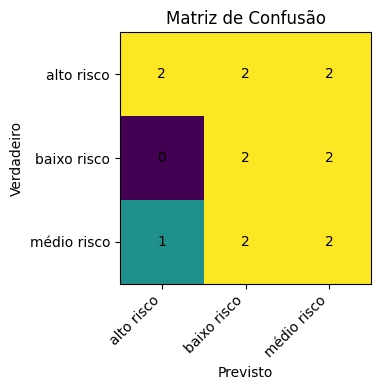

In [33]:

# Plot simples (sem estilos/cores específicas)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)  # não especificar cmap
ax.set_xticks(range(len(model.classes_)))
ax.set_yticks(range(len(model.classes_)))
ax.set_xticklabels(model.classes_, rotation=45, ha="right")
ax.set_yticklabels(model.classes_)

# Anotações nos blocos
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center")

ax.set_xlabel("Previsto")
ax.set_ylabel("Verdadeiro")
ax.set_title("Matriz de Confusão")
plt.tight_layout()
plt.show()



## 9) (Opcional) ROC‑AUC para “alto risco”
Embora acurácia e matriz de confusão sejam o foco, o **ROC‑AUC** fornece uma visão adicional de separação entre classes.


In [34]:

# Binarizar rótulos para 'alto risco' = 1
y_test_bin = (y_test == "alto risco").astype(int)
try:
    roc_auc = roc_auc_score(y_test_bin, y_proba_alto)
    print(f"ROC-AUC (alto risco vs baixo risco): {roc_auc:.3f}")
except ValueError as e:
    print("ROC-AUC não pôde ser calculado:", e)


ROC-AUC (alto risco vs baixo risco): 0.537



## 10) Inspeção de erros e possíveis padrões
Juntamos as frases de teste, rótulos verdadeiros, predições e a probabilidade de **alto risco** para inspecionar **falsos positivos/negativos**.


In [35]:

resultados = pd.DataFrame({
    "frase": X_test_text.values,
    "verdadeiro": y_test.values,
    "previsto": y_pred,
    "prob_alto_risco": y_proba_alto
})

# Erros
erros = resultados[resultados["verdadeiro"] != resultados["previsto"]]
print("Total de erros:", len(erros))
resultados.sort_values("prob_alto_risco", ascending=False).head(10)


Total de erros: 9


,frase,verdadeiro,previsto,prob_alto_risco
13,sinto dor aguda no abdômen,alto risco,alto risco,0.458761
0,sinto falta de apetite há dias,médio risco,alto risco,0.412318
5,sinto dor de ouvido,médio risco,médio risco,0.401795
3,tive um desmaio ontem,alto risco,alto risco,0.352241
7,minhas pernas estão inchadas,alto risco,médio risco,0.340686
12,acordei com dor de cabeça leve,baixo risco,médio risco,0.321374
8,tive um leve resfriado,baixo risco,baixo risco,0.299967
9,tive um leve incômodo nas costas,baixo risco,baixo risco,0.292842
2,meu pulso está irregular,alto risco,médio risco,0.291705
10,meu nariz está entupido,baixo risco,médio risco,0.291705


In [36]:

# Visualizar apenas os erros (se houver)
erros if len(erros) else resultados.head(5)


,frase,verdadeiro,previsto,prob_alto_risco
0,sinto falta de apetite há dias,médio risco,alto risco,0.412318
1,tenho dor forte nas costas,médio risco,baixo risco,0.241051
2,meu pulso está irregular,alto risco,médio risco,0.291705
6,tenho uma ferida que não cicatriza,alto risco,baixo risco,0.254028
7,minhas pernas estão inchadas,alto risco,médio risco,0.340686
10,meu nariz está entupido,baixo risco,médio risco,0.291705
11,tenho dificuldade para engolir,alto risco,baixo risco,0.216210
12,acordei com dor de cabeça leve,baixo risco,médio risco,0.321374
14,tenho tosse seca persistente,médio risco,baixo risco,0.216210



## 11) Testes com frases novas (exemplos)


In [37]:

novas_frases = [
    "sinto dor no peito e falta de ar",
    "tive uma leve dor de cabeça",
    "vômito com sangue",
    "pressão no peito ao subir escadas",
]

X_new = vectorizer.transform(novas_frases)
pred_new = model.predict(X_new)
proba_new = model.predict_proba(X_new)[:, idx_alto]

for frase, pred, p in zip(novas_frases, pred_new, proba_new):
    print(f'"{frase}" -> {pred} (prob_alto_risco={p:.2f})')


"sinto dor no peito e falta de ar" -> alto risco (prob_alto_risco=0.57)
"tive uma leve dor de cabeça" -> baixo risco (prob_alto_risco=0.28)
"vômito com sangue" -> alto risco (prob_alto_risco=0.42)
"pressão no peito ao subir escadas" -> alto risco (prob_alto_risco=0.51)



## 12) (Opcional) Salvar modelo e vetorizador
Caso queira reutilizar o classificador sem re-treinar.


In [ ]:

# from joblib import dump
# dump(model, "modelo_triagem_logreg.pkl")
# dump(vectorizer, "tfidf_vectorizer.pkl")
# print("Artefatos salvos no diretório do notebook.")



## 13) Conclusões e próximos passos
- **Tamanho/qualidade do dataset** impacta fortemente o desempenho — em uma aplicação real, precisamos incluir mais mais exemplos diversos.
- Considerar **balancear classes** (ex.: `class_weight='balanced'` na Regressão Logística) quando houver desbalanceamento, o que não foi o caso aqui, mas pode ser necessário em bases reais.
- Avaliar alternativas como **Naive Bayes** e **SVM** para comparação. Como o enunciado da atividade não pede uma comparação direta entre diferentes modelos, optamos por não fazer, mas esse seria um passo extra interessante, a fim de avaliar como cada modelo desempenharia nesse mesmo cenário.
